In [4]:
import numpy as np
import pandas as pd
from load_clean_data import load_data, clean_data, oversample

<div style="background-color: #3498db; border-radius: 10px; text-align: center; padding: 10px;">
    <h1>Data Loading</h1>
</div>


In [6]:
# Cargar y limpiar datos
data = load_data()
cleandata, X, Y = clean_data(data)
x_resampled, y_resampled = oversample(X, Y)

<div style="background-color:rgb(174, 186, 213); border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: black;">MLFlow</h1>
</div>


### Configuracion MLFLow

In [4]:
import subprocess

# Ejecutar MLFlow en segundo plano
# Simula ejecutar el comando "mlflow server --host 127.0.0.1 --port 8080"
process = subprocess.Popen(
    ["mlflow", "server", "--host", "127.0.0.1", "--port", "8080", "--backend-store-uri", "sqlite:///C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlflowfiles/mlflow.db", "--default-artifact-root", "file:///C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlflowfiles/artifacts"], 
    stdout=subprocess.PIPE,  # Captura la salida estándar
    stderr=subprocess.PIPE   # Captura errores
)

print(f"Servidor MLflow iniciado con PID {process.pid}")


Servidor MLflow iniciado con PID 2340


In [5]:
import mlflow
from mlflow.models import infer_signature

# Configurar SQLite como backend store
#mlflow.set_tracking_uri("sqlite:///C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlflowfiles/mlflow.db")

# Definir la ubicación de los artefactos
#mlflow.set_registry_uri("file:///C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlflowfiles/artifacts")

experiment_name = "logistic-regression-experiment"
#mlflow.create_experiment(experiment_name, artifact_location="file:///C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlflowfiles/artifacts")
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='file:///c:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlruns/631189094949625404', creation_time=1741097941384, experiment_id='631189094949625404', last_update_time=1741097941384, lifecycle_stage='active', name='logistic-regression-experiment', tags={}>

<div style="background-color: #ccd5ae; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: black;">Data Modelling</h1>
</div>

### Train, test and splitting the data

In [ ]:
#: Divide el dataset en dos subconjuntos:
# - 80% de los datos será para entrenar el modelo
# - 20% de los datos será para evaluar el modelo
from sklearn.model_selection import train_test_split

x_train, X_test, Y_train, Y_test = train_test_split(x_resampled,y_resampled,test_size=0.2)

### Modelo de regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Crear el modelo
model = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(x_train, Y_train)

# Realizar predicciones con los datos de prueba
y_pred = model.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.935


#### Con MLFlow

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
from mlflow.models import infer_signature
experiment_name = "logistic_regression_experiment"
mlflow.set_experiment(experiment_name)

# Definir parámetros del modelo
params = {
    "solver": "lbfgs",
    "max_iter": 100,
    "random_state": 42
}

with mlflow.start_run():
    # Registrar parámetros
    mlflow.log_params(params)

    # Crear y entrenar el modelo
    model = LogisticRegression(**params)
    model.fit(x_train, Y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average="weighted")
    recall = recall_score(Y_test, y_pred, average="weighted")
    f1 = f1_score(Y_test, y_pred, average="weighted")

    # Registrar métricas
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Capturar firma del modelo
    signature = infer_signature(x_train, model.predict(x_train))

    # Registrar el modelo
    mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path="logistic_regression_model",
    signature=signature)

    # Registrar el modelo en MLflow Model Registry
    mlflow.register_model(
        f"runs:/{mlflow.active_run().info.run_id}/logistic_regression_model",
        "logistic-regression-experiment"
    )
    
    print("registrado")


    print(f"Run ID: {mlflow.active_run().info.run_id}")  # Identificador único de este experimento

    print(f"info: {mlflow.active_run().info}")

2025/03/04 11:19:01 INFO mlflow.tracking.fluent: Experiment with name 'logistic_regression_experiment' does not exist. Creating a new experiment.


registrado
Run ID: 446817692fb0442f990b06954057a8c8
info: <RunInfo: artifact_uri='file:///c:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/mlruns/307746205249028002/446817692fb0442f990b06954057a8c8/artifacts', end_time=None, experiment_id='307746205249028002', lifecycle_stage='active', run_id='446817692fb0442f990b06954057a8c8', run_name='agreeable-chimp-336', run_uuid='446817692fb0442f990b06954057a8c8', start_time=1741097943139, status='RUNNING', user_id='Cami'>


Successfully registered model 'logistic-regression-experiment'.
Created version '1' of model 'logistic-regression-experiment'.


High accuracy is not often a good thing in a machine learning model as it states the problem of imbalanced dataset

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a 'FraudIndicator' column
# Load your data into the DataFrame if not already done

# Create a count plot for the 'FraudIndicator' column
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.countplot(data=data1, x='FraudIndicator', palette='viridis')
plt.title('Count Plot of Fraud Indicator')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()


KeyboardInterrupt: 

#### Logistic regression using sampled Data

Class distribution after oversampling: Counter({0: 955, 1: 955})


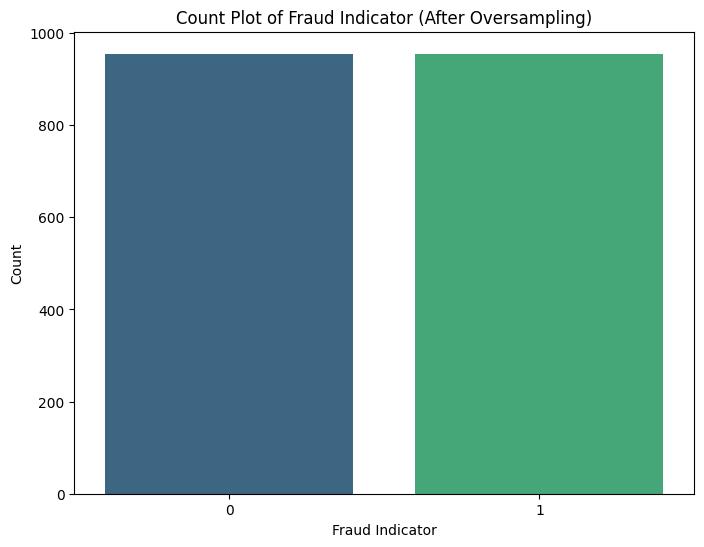

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Check the class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_resampled))

# Create a count plot for the 'FraudIndicator' column after oversampling
plt.figure(figsize=(8, 6))
sns.countplot(data=pd.DataFrame({'FraudIndicator': y_resampled}), x='FraudIndicator', palette='viridis')
plt.title('Count Plot of Fraud Indicator (After Oversampling)')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()


In [ ]:
# Retraining Logistic regression using SAMPLED Data
model = LogisticRegression()

# Train the model on the training data
model.fit(X_resampled, y_resampled)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate and print various metrics to evaluate the model's performance
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
confusion = confusion_matrix(Y_test, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Model Evaluation Metrics:
Accuracy: 0.56
Precision: 0.047058823529411764
Recall: 0.36363636363636365
F1 Score: 0.08333333333333333
Confusion Matrix:
[[108  81]
 [  7   4]]


In [ ]:
# Logistic Regression model with Sample Data with Mlflow

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Iniciar un nuevo run en MLflow
with mlflow.start_run():
    model = LogisticRegression()

    # Train the model on the training data
    model.fit(X_resampled, y_resampled)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate and print various metrics to evaluate the model's performance
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average="weighted")
    recall = recall_score(Y_test, y_pred, average="weighted")
    f1 = f1_score(Y_test, y_pred, average="weighted")
    confusion = confusion_matrix(Y_test, y_pred)

    # Registrar métricas
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Capturar firma del modelo
    signature = infer_signature(X_train, model.predict(X_train))

    # Registrar el modelo
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="logistic_regression_model_withSampleData",
        signature=signature,
        registered_model_name="logistic-regression-withSampleData-experiment"
    )

    print(f"Run ID: {mlflow.active_run().info.run_id}")  # Identificador único de este experimento

Run ID: d4f37a0a5cfd45a493c6a772420efb12


Registered model 'logistic-regression-withSampleData-experiment' already exists. Creating a new version of this model...
Created version '3' of model 'logistic-regression-withSampleData-experiment'.


#### Logistic Regression Model with Hyperparameter Tuning

Encontrar los valores óptimos de los hiperparámetros de un modelo de aprendizaje automático para mejorar su rendimiento.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
model = LogisticRegression()

# Define a range of hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': np.logspace(-3, 3, 7),  # Inverse of regularization strength (smaller values for stronger regularization)
    'solver': ['liblinear'],  # Solver for l1 regularization
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the resampled data
y_pred = best_model.predict(X_resampled)

# Calculate and print various metrics to evaluate the model's performance on the resampled data
accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred)
recall = recall_score(y_resampled, y_pred)
f1 = f1_score(y_resampled, y_pred)
confusion = confusion_matrix(y_resampled, y_pred)

print("Model Evaluation Metrics on Resampled Data:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)


Best Hyperparameters: {'C': np.float64(100.0), 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation Metrics on Resampled Data:
Accuracy: 0.6162303664921466
Precision: 0.611
Recall: 0.6397905759162303
F1 Score: 0.6250639386189258
Confusion Matrix:
[[566 389]
 [344 611]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def evaluate_classification_models(X_resampled, y_resampled):
    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Define a dictionary of classification models
    models = {
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "Random Forest Classifier": RandomForestClassifier(),
        "Support Vector Machine (SVM)": SVC(),
        "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
        "Gradient Boosting Classifier": GradientBoostingClassifier()
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate and store various metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Confusion Matrix": confusion
        }
    
    return results

results = evaluate_classification_models(X_resampled, y_resampled)
for model_name, model_result in results.items():
     print(f"Results for {model_name}:")
     for metric, value in model_result.items():
         print(f"{metric}: {value}")
     print()


Results for Decision Tree Classifier:
Accuracy: 0.8272251308900523
Precision: 0.8131313131313131
Recall: 0.8473684210526315
F1 Score: 0.8298969072164949
Confusion Matrix: [[155  37]
 [ 29 161]]

Results for Random Forest Classifier:
Accuracy: 0.9345549738219895
Precision: 0.9187817258883249
Recall: 0.9526315789473684
F1 Score: 0.9354005167958657
Confusion Matrix: [[176  16]
 [  9 181]]

Results for Support Vector Machine (SVM):
Accuracy: 0.6073298429319371
Precision: 0.6333333333333333
Recall: 0.5
F1 Score: 0.5588235294117647
Confusion Matrix: [[137  55]
 [ 95  95]]

Results for K-Nearest Neighbors (KNN):
Accuracy: 0.819371727748691
Precision: 0.759656652360515
Recall: 0.9315789473684211
F1 Score: 0.8368794326241135
Confusion Matrix: [[136  56]
 [ 13 177]]

Results for Gradient Boosting Classifier:
Accuracy: 0.8403141361256544
Precision: 0.7972350230414746
Recall: 0.9105263157894737
F1 Score: 0.8501228501228502
Confusion Matrix: [[148  44]
 [ 17 173]]



### XGBoost

In [1]:
from load_clean_data import load_data, clean_data, oversample
data = load_data()
cleandata, X, Y = clean_data(data)
x_resampled, y_resampled = oversample(X, Y)

#### Normalizar

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Copiamos el dataset para no modificar el original
x_resampled_xgb = x_resampled.copy()

# Columnas a escalar
cols_to_scale = ['TransactionAmount', 'AnomalyScore', 'Amount', 'AccountBalance', 'Hour', 'gap']

# Aplicamos StandardScaler a las columnas numéricas
scaler = StandardScaler()
x_resampled_xgb[cols_to_scale] = scaler.fit_transform(x_resampled_xgb[cols_to_scale])

# Convertimos 'Category' en variables dummy
x_resampled_xgb = pd.get_dummies(x_resampled_xgb, columns=['Category'], dtype=int)

# Dividimos en conjunto de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_resampled_xgb, y_resampled, test_size=0.2, random_state=42)

# Verificamos los tamaños
print(X_train.shape, X_test.shape)


(1528, 12) (382, 12)


In [ ]:
# Creamos el modelo XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Problema de clasificación binaria
    eval_metric='logloss',  # Logarithmic loss (buena métrica para clasificación)
    n_estimators=100,  # Número de árboles
    learning_rate=0.1,  # Tasa de aprendizaje
    max_depth=6,  # Profundidad máxima de los árboles
    subsample=0.8,  # Proporción de datos usados en cada árbol
    colsample_bytree=0.8,  # Proporción de features usadas en cada árbol
    random_state=42  # Reproducibilidad
)

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)

# Evaluamos en test
accuracy = xgb_model.score(X_test, y_test)
print(f'Accuracy del modelo: {accuracy:.4f}')


Accuracy del modelo: 0.9058


c:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [4]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones en test
y_pred = xgb_model.predict(X_test)

# Matriz de confusión
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))

# Reporte de clasificación
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Matriz de Confusión:
 [[165  32]
 [  4 181]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90       197
           1       0.85      0.98      0.91       185

    accuracy                           0.91       382
   macro avg       0.91      0.91      0.91       382
weighted avg       0.92      0.91      0.91       382



Ajuste de Hiperparámetros con GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definimos los parámetros a probar
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', 
                                            eval_metric='logloss', 
                                            use_label_encoder=False),
                           param_grid, 
                           cv=3, 
                           scoring='accuracy', 
                           verbose=1, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluamos el mejor modelo en test
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\nReporte de Clasificación con Mejores Parámetros:\n", classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}

Reporte de Clasificación con Mejores Parámetros:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93       197
           1       0.89      0.99      0.94       185

    accuracy                           0.93       382
   macro avg       0.94      0.94      0.93       382
weighted avg       0.94      0.93      0.93       382



### Red Neuronal Profunda

In [ ]:
from load_clean_data import load_data, clean_data, oversample
data = load_data()
cleandata, X, Y = clean_data(data)
x_resampled, y_resampled = oversample(X, Y)
print(y_resampled)

0       0
1       0
2       0
3       0
4       0
       ..
1905    1
1906    1
1907    1
1908    1
1909    1
Name: FraudIndicator, Length: 1910, dtype: int64


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

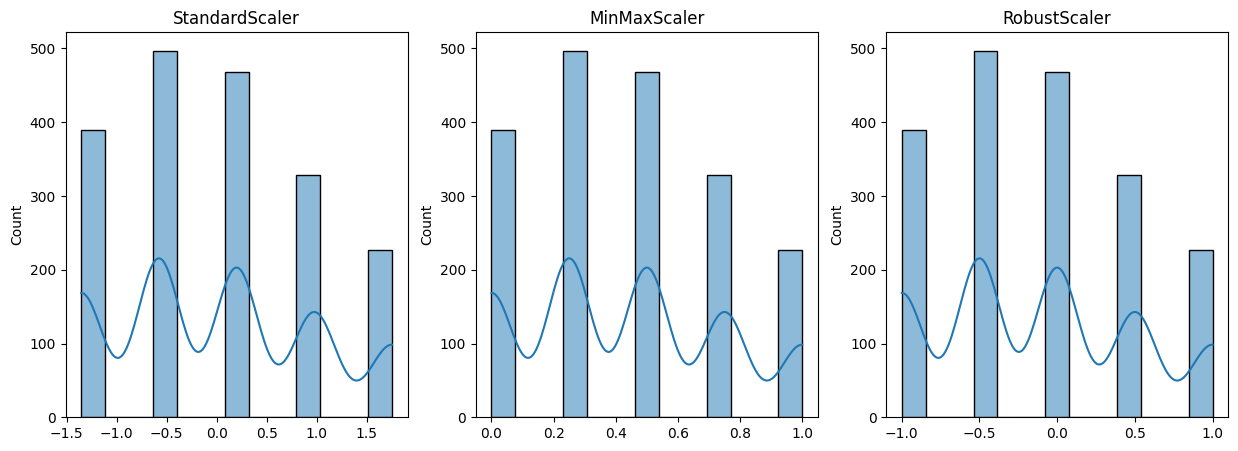

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# Aplicar diferentes escaladores y comparar
scaled_data = {}
for name, scaler in scalers.items():
    scaled_data[name] = scaler.fit_transform(X_resampled)

# Ver cómo cambia la distribución después del escalado
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, data) in enumerate(scaled_data.items()):
    sns.histplot(data[:, 0], ax=axes[i], kde=True)  # Graficamos la primera columna escalada
    axes[i].set_title(name)

plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 1. Normalizar variables

# Columnas que necesitan normalización (todas excepto las categóricas y binarias)
cols_to_scale = ['TransactionAmount', 'AnomalyScore', 'Amount', 'AccountBalance', 'Hour', 'gap']

# Inicializamos StandardScaler
scaler = StandardScaler()

# Aplicamos la normalización
X_resampled_scaled = X_resampled.copy()
X_resampled_scaled[cols_to_scale] = scaler.fit_transform(X_resampled[cols_to_scale])

# Convertimos 'Category' en one-hot encoding
X_resampled_scaled = pd.get_dummies(X_resampled_scaled, columns=['Category'], dtype=int)

# Verificamos el resultado
print(X_resampled_scaled.head())


   TransactionAmount  AnomalyScore    Amount  AccountBalance  SuspiciousFlag  \
0           1.079004      0.839766 -0.024997       -1.173418               0   
1           1.549685     -1.556235 -0.102979       -1.173418               0   
2          -1.801095     -1.404392 -1.826234        1.569766               0   
3          -0.892209     -1.619152 -0.251117        1.471055               0   
4          -1.448685      0.061157 -0.132235        1.471055               0   

       Hour       gap  Category_0  Category_1  Category_2  Category_3  \
0 -1.676618  1.677710           0           0           1           0   
1 -0.779813  1.537958           1           0           0           0   
2 -1.527151 -1.816077           0           1           0           0   
3 -1.377683  1.689041           0           0           0           0   
4  0.565394  1.605945           0           0           0           1   

   Category_4  
0           0  
1           0  
2           0  
3           1  


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Número de características después de normalización y one-hot encoding
input_dim = X_resampled_scaled.shape[1]

# Definimos la red neuronal
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),  # Capa oculta 1
        Dropout(0.2),  # Regularización
        Dense(32, activation='relu'),  # Capa oculta 2
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Capa de salida (detección de fraude)
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Creamos el modelo
model = build_model()

# Mostramos la arquitectura
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Dividimos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Entrenamos la red neuronal
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
48/48 [==============================] - 3s 12ms/step - loss: 0.6731 - accuracy: 0.5838 - val_loss: 0.6324 - val_accuracy: 0.6859
Epoch 2/50
48/48 [==============================] - 0s 6ms/step - loss: 0.6213 - accuracy: 0.6721 - val_loss: 0.5889 - val_accuracy: 0.7330
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 0.5889 - accuracy: 0.6918 - val_loss: 0.5543 - val_accuracy: 0.7304
Epoch 4/50
48/48 [==============================] - 0s 5ms/step - loss: 0.5547 - accuracy: 0.7225 - val_loss: 0.5281 - val_accuracy: 0.7356
Epoch 5/50
48/48 [==============================] - 0s 6ms/step - loss: 0.5301 - accuracy: 0.7402 - val_loss: 0.5054 - val_accuracy: 0.7670
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 0.5052 - accuracy: 0.7572 - val_loss: 0.4849 - val_accuracy: 0.7775
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.7736 - val_loss: 0.4660 - val_accuracy: 0.7801
Epoch 8/50
48/48 [=

# ANTERIOR: Ranking Models perfromance
1. Random Forest Classifier
2. Gradient Boosting Algorithm
3. Decision Tree Classifier
4. K-Nearest Neighbours
5. Support Vector Machine (SVC)
6. Logistic Regression

Now we can HyperParameterTune the

## RandomForest CLassifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Define a range of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the resampled data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Train the best model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate and print various metrics to evaluate the best model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Best Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)


Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Model Evaluation Metrics:
Accuracy: 0.9293193717277487
Precision: 0.9014778325123153
Recall: 0.9631578947368421
F1 Score: 0.9312977099236641
Confusion Matrix:
[[172  20]
 [  7 183]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Escalar los datos (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear la red neuronal
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32)

# Evaluar
accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy (DNN):", accuracy[1])

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5900 - loss: 0.6655 - val_accuracy: 0.6601 - val_loss: 0.6148
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6226 - loss: 0.6161 - val_accuracy: 0.7124 - val_loss: 0.5842
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6863 - loss: 0.5781 - val_accuracy: 0.7386 - val_loss: 0.5666
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6886 - loss: 0.5628 - val_accuracy: 0.7614 - val_loss: 0.5467
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7159 - loss: 0.5298 - val_accuracy: 0.7712 - val_loss: 0.5322
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7557 - loss: 0.5065 - val_accuracy: 0.7908 - val_loss: 0.5131
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7650 - loss: 0.4871 - val_accuracy: 0.7974 - val_loss: 0.5090
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7704 - loss: 0.4782 - val_accuracy: 0.7908 - val_loss:

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest
y_pred_rf = best_rf_model.predict(X_test)
print("Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

# Red Neuronal
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Neural Network Metrics:")
print(classification_report(y_test, y_pred_nn))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nn))


Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       192
           1       0.90      0.96      0.93       190

    accuracy                           0.93       382
   macro avg       0.93      0.93      0.93       382
weighted avg       0.93      0.93      0.93       382

ROC-AUC: 0.9294956140350877
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Neural Network Metrics:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       192
           1       0.80      0.96      0.87       190

    accuracy                           0.86       382
   macro avg       0.88      0.86      0.86       382
weighted avg       0.88      0.86      0.86       382

ROC-AUC: 0.8617598684210526
